In [3]:
# !pip install odfpy
import numpy as np
import pandas as pd


file = pd.ExcelFile('Wijkdata_Jeugdhulp_in_de_wijk.ods')

sheet_names = file.sheet_names

wijk = pd.read_excel(file, sheet_name=sheet_names[-3])  # wijk
gebr = pd.read_excel(file, sheet_name=sheet_names[-2])  # gebruik
det = pd.read_excel(file, sheet_name=sheet_names[-1])  # determinanten

file.close()

In [4]:
df = det.copy()
# als je wijk en gemeentecode hebt heb je wijkcode en gemeentenaam niet nodig
df = df.merge(wijk[['wijk', 'gemeentecode']], on='wijk', how='left')
# per_jhzv : aandeel jeugdigen met jeugdhulp zonder verblijf, waargenomen -> target variable
df = df.merge(gebr[['wijk', 'perc_jhzv']], on='wijk', how='left')

for col in df.columns:
    df[col] = df[col].apply(lambda x: x if x != '.' else np.nan)

# TODO is nu missig values vullen met gemiddelde hoe willen we dat doen?
df.fillna(df.mean(), inplace=True)

# hun schatting root mean squared error (residu = schatting - waargenomen)
for col in gebr.columns:
    gebr[col] = gebr[col].apply(lambda x: x if x != '.' else np.nan)

# drop missende schattingen en bereken RMSE
original_rmse = str((gebr.dropna(subset='residu')['residu']**2).mean()**0.5)

df

,wijk,perc_sbo_g,perc_vso_g,perc_praktijk_g,perc_hhmk,perc_jong04,perc_1ouder,perc_tienmam,perc_hhmkhgink,perc_kind_sch5,...,perc_nwmig,perc_antsur,perc_1gez,huur_corp,woonwaarde,afstandhuisarts,samenw,kleinewijk,gemeentecode,perc_jhzv
0,300,0.7,0.6,1.0,23.646,30.840,24.27500,0.606,3.664000,5.869000,...,6.140,1.462,72.0,44.0,134.0,1.4,0,0,3,12.489
1,500,0.5,0.5,0.6,27.875,32.353,14.70600,0.615,4.657000,6.727000,...,3.055,0.477,86.0,23.0,174.0,1.1,1,0,5,12.434
2,700,0.5,0.9,1.3,20.911,27.822,18.89800,0.917,3.937000,5.646000,...,4.094,0.248,94.0,19.0,157.0,2.0,0,0,7,12.195
3,701,0.5,0.9,1.3,17.156,36.842,17.66441,0.917,11.859103,5.750111,...,1.546,0.515,100.0,7.0,177.0,4.1,0,1,7,19.333
4,702,0.5,0.9,1.3,20.957,29.620,17.12000,0.917,5.978000,6.317000,...,2.299,0.383,92.0,23.0,165.0,1.0,0,0,7,9.834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2913,195502,0.7,1.3,0.9,25.680,29.929,13.81800,0.283,6.663000,5.747000,...,3.661,0.565,84.0,27.0,199.0,1.1,1,0,1955,11.274
2914,198700,0.4,1.0,1.1,25.822,21.394,17.78800,0.275,4.808000,5.035000,...,3.769,0.538,95.0,22.0,156.0,1.2,0,0,1987,15.616
2915,198701,0.4,1.0,1.1,25.628,35.294,14.21600,0.275,5.392000,6.105000,...,1.604,0.535,95.0,27.0,152.0,4.2,0,0,1987,19.143
2916,198702,0.4,1.0,1.1,25.472,28.571,17.98900,0.275,5.291000,8.682000,...,1.780,0.297,96.0,19.0,158.0,1.4,0,0,1987,13.438


In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


X = df.drop('perc_jhzv', axis=1)
y = df['perc_jhzv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Predict the test data
y_pred = model.predict(X_test)

# Calculate RMSE of the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Model RMSE : ", rmse)
print("their Model RMSE: ", original_rmse)


Model RMSE :  2.877793232553326
their Model RMSE:  2.2551381084753706


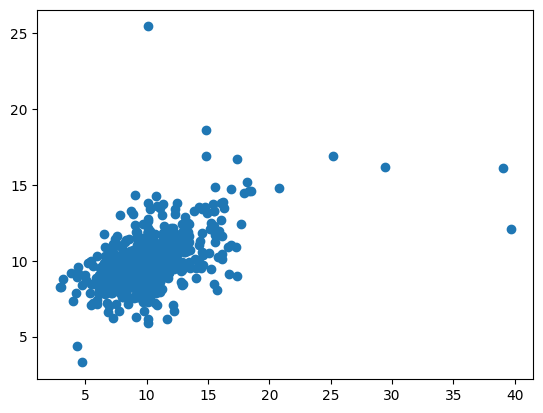

In [8]:
import matplotlib.pyplot as plt

plt.scatter(y=y_pred, x=y_test)

In [7]:
import geopandas as gpd


buurt = gpd.read_file('./WijkBuurtkaart_2022_v1/buurt_2022_v1.shp')
wijk = gpd.read_file('./WijkBuurtkaart_2022_v1/wijk_2022_v1.shp')
gemeente = gpd.read_file('./WijkBuurtkaart_2022_v1/gemeente_2022_v1.shp')

print(wijk.head())

    WK_CODE WK_NAAM GM_CODE        GM_NAAM   IND_WBI H2O       OAD      STED  \
0  WK040099     NaN  GM0400     Den Helder -99999999  JA -99999999 -99999999   
1  WK057599     NaN  GM0575      Noordwijk -99999999  JA -99999999 -99999999   
2  WK031399     NaN  GM0313     Bunschoten -99999999  JA -99999999 -99999999   
3  WK037399     NaN  GM0373   Bergen (NH.) -99999999  JA -99999999 -99999999   
4  WK051899     NaN  GM0518  's-Gravenhage -99999999  JA -99999999 -99999999   

   BEV_DICHTH  AANT_INW  ...  P_TURKIJE  P_OVER_NW   OPP_TOT  OPP_LAND  \
0   -99999999 -99999999  ...  -99999999  -99999999 -99999999 -99999999   
1   -99999999 -99999999  ...  -99999999  -99999999 -99999999 -99999999   
2   -99999999 -99999999  ...  -99999999  -99999999 -99999999 -99999999   
3   -99999999 -99999999  ...  -99999999  -99999999 -99999999 -99999999   
4   -99999999 -99999999  ...  -99999999  -99999999 -99999999 -99999999   

   OPP_WATER    JRSTATCODE  JAAR    Shape_Leng    Shape_Area  \
0  -999999

In [15]:
buurt.columns

Index(['BU_CODE', 'BU_NAAM', 'WK_CODE', 'GM_CODE', 'GM_NAAM', 'IND_WBI', 'H2O',
       'POSTCODE', 'DEK_PERC', 'OAD', 'STED', 'BEV_DICHTH', 'AANT_INW',
       'AANT_MAN', 'AANT_VROUW', 'P_00_14_JR', 'P_15_24_JR', 'P_25_44_JR',
       'P_45_64_JR', 'P_65_EO_JR', 'P_ONGEHUWD', 'P_GEHUWD', 'P_GESCHEID',
       'P_VERWEDUW', 'AANTAL_HH', 'P_EENP_HH', 'P_HH_Z_K', 'P_HH_M_K',
       'GEM_HH_GR', 'P_WEST_AL', 'P_N_W_AL', 'P_MAROKKO', 'P_ANT_ARU',
       'P_SURINAM', 'P_TURKIJE', 'P_OVER_NW', 'OPP_TOT', 'OPP_LAND',
       'OPP_WATER', 'JRSTATCODE', 'JAAR', 'Shape_Leng', 'Shape_Area',
       'geometry'],
      dtype='object')

In [12]:
gemeente.columns

Index(['GM_CODE', 'GM_NAAM', 'H2O', 'OAD', 'STED', 'BEV_DICHTH', 'AANT_INW',
       'AANT_MAN', 'AANT_VROUW', 'P_00_14_JR', 'P_15_24_JR', 'P_25_44_JR',
       'P_45_64_JR', 'P_65_EO_JR', 'P_ONGEHUWD', 'P_GEHUWD', 'P_GESCHEID',
       'P_VERWEDUW', 'AANTAL_HH', 'P_EENP_HH', 'P_HH_Z_K', 'P_HH_M_K',
       'GEM_HH_GR', 'P_WEST_AL', 'P_N_W_AL', 'P_MAROKKO', 'P_ANT_ARU',
       'P_SURINAM', 'P_TURKIJE', 'P_OVER_NW', 'OPP_TOT', 'OPP_LAND',
       'OPP_WATER', 'JRSTATCODE', 'JAAR', 'Shape_Leng', 'Shape_Area',
       'geometry'],
      dtype='object')

In [10]:
buurt.columns

Index(['BU_CODE', 'BU_NAAM', 'WK_CODE', 'GM_CODE', 'GM_NAAM', 'IND_WBI', 'H2O',
       'POSTCODE', 'DEK_PERC', 'OAD', 'STED', 'BEV_DICHTH', 'AANT_INW',
       'AANT_MAN', 'AANT_VROUW', 'P_00_14_JR', 'P_15_24_JR', 'P_25_44_JR',
       'P_45_64_JR', 'P_65_EO_JR', 'P_ONGEHUWD', 'P_GEHUWD', 'P_GESCHEID',
       'P_VERWEDUW', 'AANTAL_HH', 'P_EENP_HH', 'P_HH_Z_K', 'P_HH_M_K',
       'GEM_HH_GR', 'P_WEST_AL', 'P_N_W_AL', 'P_MAROKKO', 'P_ANT_ARU',
       'P_SURINAM', 'P_TURKIJE', 'P_OVER_NW', 'OPP_TOT', 'OPP_LAND',
       'OPP_WATER', 'JRSTATCODE', 'JAAR', 'Shape_Leng', 'Shape_Area',
       'geometry'],
      dtype='object')